# SA GAWLER CHALLENGE - FROM DATA CLEANING TO MACHINE LEARNING
# *Bridging the Gap between Geologists and Data Scientists!* 

-- By INCERTO DATA (Russell Menezes, Ahmad Saleem)

Our submission revolved around trying to clean and setup the state wide geochemical data supplied by the South Australian geological survey - with particular attention to handling the various populations present within the geochemical dataset - and then using this base geochemical dataset in conjunction with gridded geophysical data (not images) to create a training dataset that could be used for a machine learning model. 

The process that we have highlighted is not meant to be prescriptive but our attempt at understanding how best to handle the spatial variability present within the geochemical and geophysical datasets.

Please note that we have only focussed on the gold assay data available in the geochemical dataset. But the process could be repeated for other elements as well.

#### 1. Handling Different Sample Populations

Statewide geochemical datasets are usually a collection of decades worth of various samples collected by various entities (including the geological survey but also numerous mining and exploration companies) combined into one dataset irrespective of what the different samples are or when they were collected. The intention behind creating this single dataset is to make it easy for the end user to work with. But it creates the unintended problem of combining various populations into the one dataset. The end user must decide how to handle the various populations within the dataset. 

There are several reasons for the various populations in these geochemical datasets. The two most common culprits are:
- Different samples types present 
- Different analysis methods being included. This leads to different elements present for each sample (i.e. not all elements are available for each sample) and can also lead to differences in absolute elemental values reported for each element.

Before deciding to use this dataset, it is worth understanding what effect these different populations have and how best to minimise that. 

#### 2. Integrating Geochemical Data with Geophysical Grids (Not RGB Images)

Once the geochemical dataset was normalised to the various populations within it, we attempted to correlate it to the available geophysical (magnetics and gravity) datasets available. Instead of using the interpreted images, we used the available gridded data. The intention was to create a training dataset that combines geochemical and the geophysical data with anomalous gold values as the predictor. 

#### 3. What is the X and y? Regression or Classification? Formulating the Machine Learning Problem

At the end, we open it up for discussion on how best to approach this in creating a machine learning model - i.e. whether it is best to create a classification model or a regression model. 

Our belief was that setting up the test as a classification problem is likely to deliver better results as it is hard to imagine it being possible to predict gold assay values based on geophysical data. Whereas it is more conceivable to have geophysical responses related to anomalous gold features highlighted through the classification test. 

We created the dataset to test both but we left it there for this submission as we ran out of time to fully test and report our models.


In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)


import os
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#Change according to your folder structure

os.chdir('..')
os.getcwd()

'H:\\ExploreSA'

### Extracting Au data from the master assay data set

We used the techniques as mentioned in the notebooks posted by Russell Menezes (RadixGeo) to extract just the gold assay data from the larger statewide geochemical data set.

If you need a refresher check the [RadixGeo Github here.](https://github.com/radixgeo/ExploreSAGawler)

Let's load the data set and begin!

In [ ]:
df_raw = pd.read_csv('Cleaned_datasets/Assay_Gold_extracted.csv')

C:\Users\Russell\Anaconda3\envs\PythonGPU\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,14,29,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 1. PREVIEWING DATA

Below is a preview of the SARIG geochemical dataset subset for all the analyses for Au in the dataset. 

The key fields to note are: 
1. *SAMPLE_SOURCE* - This designates the type of sample collected (i.e. drilling core sample, surface sample, etc.

2. *CHEM_METHOD_CODE* - This designates the type of analytical method used to determine the value of an element present in the sample.


In [ ]:
df_raw.head()

,0,SAMPLE_NO,SAMPLE_SOURCE_CODE,SAMPLE_SOURCE,ROCK_GROUP_CODE,ROCK_GROUP,LITHO_CODE,LITHO_CONF,LITHOLOGY_NAME,LITHO_MODIFIER,MAP_SYMBOL,STRAT_CONF,STRAT_NAME,COLLECTED_BY,COLLECTORS_NUMBER,COLLECTED_DATE,DRILLHOLE_NUMBER,DH_NAME,DH_DEPTH_FROM,DH_DEPTH_TO,SITE_NO,EASTING_GDA2020,NORTHING_GDA2020,ZONE_GDA2020,LONGITUDE_GDA2020,LATITUDE_GDA2020,LONGITUDE_GDA94,LATITUDE_GDA94,SAMPLE_ANALYSIS_NO,OTHER_ANALYSIS_ID,ANALYSIS_TYPE_DESC,LABORATORY,CHEM_CODE,VALUE,UNIT,CHEM_METHOD_CODE,CHEM_METHOD_DESC,Sample_no_au,AU
0,20784.0,4871,RO,Rock outcrop / float,IFI,Igneous Felsic Intrusive,ADML,NaN,Adamellite,NaN,Ll,NaN,Lincoln Complex,"BLISSETT, A.H.",FB1/5031/1,18/10/1973,NaN,NaN,NaN,NaN,130575,283095.17,6560233.31,53,132.726516,-31.071671,132.726507,-31.071657,10101,NaN,GEOCHEMISTRY,NaN,Au,<0.05,ppm,A1,A1,4871.0,1.0
1,4991.0,6171,RO,Rock outcrop / float,IFE,Igneous Felsic Extrusive,RHYO,NaN,Rhyolite,NaN,L-n,NaN,Nuyts Volcanics,"MAJOR, R.B.",NaN,10/02/1974,NaN,NaN,NaN,NaN,204856,327060.59,6386901.28,53,133.156259,-32.641976,133.156250,-32.641962,3518,NaN,GEOCHEMISTRY,NaN,Au,<0.05,ppm,NaN,NaN,6171.0,1.0
2,20808.0,6177,RO,Rock outcrop / float,IFI,Igneous Felsic Intrusive,GRNT,NaN,Granite,NaN,NaN,NaN,NaN,"MAJOR, R.B.",NaN,20/03/1974,NaN,NaN,NaN,NaN,204862,327095.87,6386987.85,53,133.156651,-32.641201,133.156642,-32.641187,10156,NaN,GEOCHEMISTRY,NaN,Au,<0.05,ppm,NaN,NaN,6177.0,1.0
3,20837.0,6183,RO,Rock outcrop / float,IFE,Igneous Felsic Extrusive,RHYD,NaN,Rhyodacite,NaN,L-n,NaN,Nuyts Volcanics,"MAJOR, R.B.",NaN,20/03/1974,NaN,NaN,NaN,NaN,131235,336057.75,6401893.09,53,133.254761,-32.508170,133.254752,-32.508156,10158,NaN,GEOCHEMISTRY,NaN,Au,<0.05,ppm,NaN,NaN,6183.0,1.0
4,5087.0,6184,RO,Rock outcrop / float,IFI,Igneous Felsic Intrusive,GRNT,NaN,Granite,NaN,Ll,NaN,Lincoln Complex,"MAJOR, R.B.",NaN,10/02/1974,NaN,NaN,NaN,NaN,131235,336057.75,6401893.09,53,133.254761,-32.508170,133.254752,-32.508156,3538,NaN,GEOCHEMISTRY,NaN,Au,<0.05,ppm,NaN,NaN,6184.0,1.0


### 2. CLEANING DATASET

##### Removing Unwanted Columns

To make the dataset more manageable, some of the unwanted and redundant columns were removed from the dataset.


In [ ]:
df = df_raw.drop(['LITHO_CODE', 'LITHO_CONF', 'LITHO_MODIFIER', 'MAP_SYMBOL', 'COLLECTORS_NUMBER','Sample_no_au', 'AU', 'OTHER_ANALYSIS_ID'], axis=1)
df = df.rename(columns={'0':'MASTER_INDEX'})

In [ ]:
df.head()

,MASTER_INDEX,SAMPLE_NO,SAMPLE_SOURCE_CODE,SAMPLE_SOURCE,ROCK_GROUP_CODE,ROCK_GROUP,LITHOLOGY_NAME,STRAT_CONF,STRAT_NAME,COLLECTED_BY,COLLECTED_DATE,DRILLHOLE_NUMBER,DH_NAME,DH_DEPTH_FROM,DH_DEPTH_TO,SITE_NO,EASTING_GDA2020,NORTHING_GDA2020,ZONE_GDA2020,LONGITUDE_GDA2020,LATITUDE_GDA2020,LONGITUDE_GDA94,LATITUDE_GDA94,SAMPLE_ANALYSIS_NO,ANALYSIS_TYPE_DESC,LABORATORY,CHEM_CODE,VALUE,UNIT,CHEM_METHOD_CODE,CHEM_METHOD_DESC
0,20784.0,4871,RO,Rock outcrop / float,IFI,Igneous Felsic Intrusive,Adamellite,NaN,Lincoln Complex,"BLISSETT, A.H.",18/10/1973,NaN,NaN,NaN,NaN,130575,283095.17,6560233.31,53,132.726516,-31.071671,132.726507,-31.071657,10101,GEOCHEMISTRY,NaN,Au,<0.05,ppm,A1,A1
1,4991.0,6171,RO,Rock outcrop / float,IFE,Igneous Felsic Extrusive,Rhyolite,NaN,Nuyts Volcanics,"MAJOR, R.B.",10/02/1974,NaN,NaN,NaN,NaN,204856,327060.59,6386901.28,53,133.156259,-32.641976,133.156250,-32.641962,3518,GEOCHEMISTRY,NaN,Au,<0.05,ppm,NaN,NaN
2,20808.0,6177,RO,Rock outcrop / float,IFI,Igneous Felsic Intrusive,Granite,NaN,NaN,"MAJOR, R.B.",20/03/1974,NaN,NaN,NaN,NaN,204862,327095.87,6386987.85,53,133.156651,-32.641201,133.156642,-32.641187,10156,GEOCHEMISTRY,NaN,Au,<0.05,ppm,NaN,NaN
3,20837.0,6183,RO,Rock outcrop / float,IFE,Igneous Felsic Extrusive,Rhyodacite,NaN,Nuyts Volcanics,"MAJOR, R.B.",20/03/1974,NaN,NaN,NaN,NaN,131235,336057.75,6401893.09,53,133.254761,-32.508170,133.254752,-32.508156,10158,GEOCHEMISTRY,NaN,Au,<0.05,ppm,NaN,NaN
4,5087.0,6184,RO,Rock outcrop / float,IFI,Igneous Felsic Intrusive,Granite,NaN,Lincoln Complex,"MAJOR, R.B.",10/02/1974,NaN,NaN,NaN,NaN,131235,336057.75,6401893.09,53,133.254761,-32.508170,133.254752,-32.508156,3538,GEOCHEMISTRY,NaN,Au,<0.05,ppm,NaN,NaN


Let's look at a summary for the dataframe (index dtype, column dtypes, non-null values and memory usage).

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1438639 entries, 0 to 1438638
Data columns (total 31 columns):
MASTER_INDEX          1438639 non-null float64
SAMPLE_NO             1438639 non-null int64
SAMPLE_SOURCE_CODE    1438367 non-null object
SAMPLE_SOURCE         1438367 non-null object
ROCK_GROUP_CODE       58066 non-null object
ROCK_GROUP            58066 non-null object
LITHOLOGY_NAME        58066 non-null object
STRAT_CONF            14253 non-null object
STRAT_NAME            50792 non-null object
COLLECTED_BY          1436880 non-null object
COLLECTED_DATE        1397754 non-null object
DRILLHOLE_NUMBER      1152105 non-null float64
DH_NAME               1152097 non-null object
DH_DEPTH_FROM         1152104 non-null float64
DH_DEPTH_TO           1151269 non-null float64
SITE_NO               1438639 non-null int64
EASTING_GDA2020       1438639 non-null float64
NORTHING_GDA2020      1438639 non-null float64
ZONE_GDA2020          1438639 non-null int64
LONGITUDE_GDA2020   

#### Cleaning Up Assay Values

In a dataset that is as multi-faceted as this state-wide geochemical dataset, there are bound to be some corrections that have to be made to the assay values. The most common correction is removing non-numeric values. 

Non-numeric values are common place in most geochemical datasets usually with the symbol "<" and rarely with the symbol ">". The former denotes values below detection limit for a specific analytical method. The latter similarly for values outside of the analytical range. 

A basic correction was applied here by taking off the symbols and leaving the number. However, it is recommended that the user accounts for these values in a better way - this comes to bite us later on.


In [ ]:
#Find symbols in the values column

sym_find_list = [re.findall(r'\D', str(i)) for i in values]
unique_symbols = set([item for sublist in sym_find_list for item in sublist])
unique_symbols

{'.', '<', '>'}

Removing symbols, converting columns to the right data types and converting assay values to the same unit.

In [ ]:
#Removing the symbols
df['VALUE_INT'] = df.VALUE.apply(lambda x: str(x).strip('<').strip('>'))

In [ ]:
#Converting the value column to float
df['VALUE_INT'] = df.VALUE_INT.astype(float)

In [ ]:
#Converting units
df['VALUE_INT_PPM'] = np.where(df.UNIT == 'ppb', df.VALUE_INT/1000, (np.where(df.UNIT == '%', df.VALUE_INT*10000, df.VALUE_INT)))

In [ ]:
#dropping rows with cps units
df = df[df.UNIT != 'cps']

In [ ]:
df.head()

,MASTER_INDEX,SAMPLE_NO,SAMPLE_SOURCE_CODE,SAMPLE_SOURCE,ROCK_GROUP_CODE,ROCK_GROUP,LITHOLOGY_NAME,STRAT_CONF,STRAT_NAME,COLLECTED_BY,COLLECTED_DATE,DRILLHOLE_NUMBER,DH_NAME,DH_DEPTH_FROM,DH_DEPTH_TO,SITE_NO,EASTING_GDA2020,NORTHING_GDA2020,ZONE_GDA2020,LONGITUDE_GDA2020,LATITUDE_GDA2020,LONGITUDE_GDA94,LATITUDE_GDA94,SAMPLE_ANALYSIS_NO,ANALYSIS_TYPE_DESC,LABORATORY,CHEM_CODE,VALUE,UNIT,CHEM_METHOD_CODE,CHEM_METHOD_DESC,VALUE_INT,VALUE_INT_PPM
0,20784.0,4871,RO,Rock outcrop / float,IFI,Igneous Felsic Intrusive,Adamellite,NaN,Lincoln Complex,"BLISSETT, A.H.",18/10/1973,NaN,NaN,NaN,NaN,130575,283095.17,6560233.31,53,132.726516,-31.071671,132.726507,-31.071657,10101,GEOCHEMISTRY,NaN,Au,<0.05,ppm,A1,A1,0.05,0.05
1,4991.0,6171,RO,Rock outcrop / float,IFE,Igneous Felsic Extrusive,Rhyolite,NaN,Nuyts Volcanics,"MAJOR, R.B.",10/02/1974,NaN,NaN,NaN,NaN,204856,327060.59,6386901.28,53,133.156259,-32.641976,133.156250,-32.641962,3518,GEOCHEMISTRY,NaN,Au,<0.05,ppm,NaN,NaN,0.05,0.05
2,20808.0,6177,RO,Rock outcrop / float,IFI,Igneous Felsic Intrusive,Granite,NaN,NaN,"MAJOR, R.B.",20/03/1974,NaN,NaN,NaN,NaN,204862,327095.87,6386987.85,53,133.156651,-32.641201,133.156642,-32.641187,10156,GEOCHEMISTRY,NaN,Au,<0.05,ppm,NaN,NaN,0.05,0.05
3,20837.0,6183,RO,Rock outcrop / float,IFE,Igneous Felsic Extrusive,Rhyodacite,NaN,Nuyts Volcanics,"MAJOR, R.B.",20/03/1974,NaN,NaN,NaN,NaN,131235,336057.75,6401893.09,53,133.254761,-32.508170,133.254752,-32.508156,10158,GEOCHEMISTRY,NaN,Au,<0.05,ppm,NaN,NaN,0.05,0.05
4,5087.0,6184,RO,Rock outcrop / float,IFI,Igneous Felsic Intrusive,Granite,NaN,Lincoln Complex,"MAJOR, R.B.",10/02/1974,NaN,NaN,NaN,NaN,131235,336057.75,6401893.09,53,133.254761,-32.508170,133.254752,-32.508156,3538,GEOCHEMISTRY,NaN,Au,<0.05,ppm,NaN,NaN,0.05,0.05


#### Checking the Distribution of the Assay Values

Looking at the distribution of Au assay values, we notice that on the higher end we have values of up to 50000ppm. These values are completely non-sensical with the likely cause of them being either due to an error in inputting the values or an error in unit conversion. 

As a sidenote, any value above 1000ppm should be scrunitised as it is highly unlikely that it is a legitimate value.

Also, we can go to the original reports related to these samples to check the values but at this point we did not bother doing this. We choose to flag these values and removed them from the dataset.

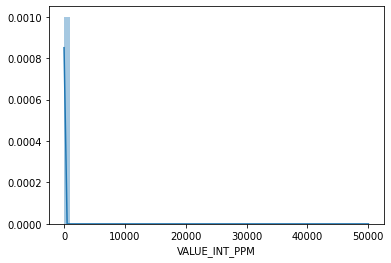

In [ ]:
s = sns.distplot(df.VALUE_INT_PPM)

After eliminating the values that we highlighted as having issues, the resultant distribution looks much better. 

Almost 76% of the data set is less than 0.05ppm and what we would consider true Au anomalies only account for less than 10-15% of the data depending on what threshold one chooses. This may seem like a very skewed distribution but it is what we would expect, since it is unrealistic to have wide spread anomalism present in the geochemical dataset. Otherwise, the threshold you are using it probably too low and needs to be higher. 

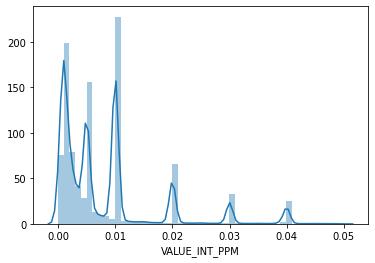

In [ ]:
sns.distplot(df.VALUE_INT_PPM[df.VALUE_INT_PPM < 0.05])

In [ ]:
print('Percentage of Values less than 0.05 is {}%'.format(len(df[df.VALUE_INT_PPM < 0.05])/len(df)*100))

Percentage of Values less than 0.05 is 75.8765750129115%


### 3. HANDLING DIFFERENT POPULATIONS

#### Distribution of Sample Types Present

In the geochemical dataset, the type of sample collected is presented in the *SAMPLE_SOURCE_CODE* column. As mentioned previously, these state-wide datasets are an amalgamation of various samples types and it is worth understanding what they are. 

Below is a count, percent count and count plot of all the different sample types present and the total percentage each category makes up in the total dataset.

In [ ]:
#Counts
df.SAMPLE_SOURCE_CODE.value_counts()

CT       539089
CALC     212237
INT      205685
DC       194849
HCORE    192856
SO        41541
CS        14473
RO        12275
AUGER      6553
SS         5352
QCORE      4566
BLEG       2554
VEG        1296
GRVL       1283
CST        1103
SLAB        756
CHNL        666
ASTD        253
PULP        249
MS          199
MM          152
DUPL        120
LAG         105
MT           56
ACR          36
SCAT         23
ROS          22
LOAM         12
MSP           4
CLR           1
BULK          1
Name: SAMPLE_SOURCE_CODE, dtype: int64

In [ ]:
#Percent counts
df.SAMPLE_SOURCE.value_counts()/df.SAMPLE_SOURCE.value_counts().sum()*100

Drill cuttings                                                  37.479239
Calcrete                                                        14.755414
Drilled interval rock sample, type unspecified                  14.299897
Drill core                                                      13.546543
Sawn half drill core                                            13.407983
Soil                                                             2.888067
Core sludge                                                      1.006211
Rock outcrop / float                                             0.853398
Auger sample from near surface                                   0.455586
Stream sediment                                                  0.372089
Sawn quarter drill core                                          0.317443
Sample specifically for bulk leach extractable gold analysis     0.177562
Vegetation                                                       0.090102
Gravel                                

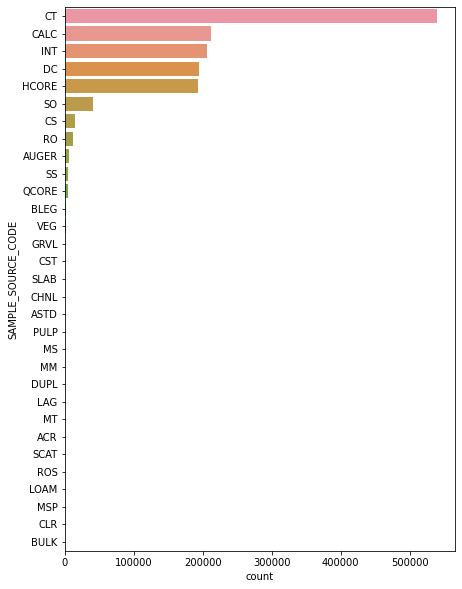

In [ ]:
#Count PLot
plt.figure(figsize=(7,10))
sns.countplot(y='SAMPLE_SOURCE_CODE', data=df, order=df.SAMPLE_SOURCE_CODE.value_counts().index)

As is, the dataset currently has way too many categories for sample type. Splitting them into all these catgories makes it hard to find any meaningful comparison between them. 
By studying the sample descriptions, one realises that a lot of the sample type are derivatives of each other. This information can be used to minimise the sample type categories by grouping some of them together.

We created these groups manually and integrated back into our dataframe.


In [ ]:
#Loading groups data
df_groups = pd.read_csv('Cleaned_datasets/tmp/Sample_source_counts.csv')

In [ ]:
df_groups

,ORIGINAL_SAMPLE_SOURCE,AMENDED_SAMPLE_SOURCE
0,Vegetation,Bio Sample
1,Excrement of animals,Bio Sample
2,Drill cuttings,Drill Sample
3,"Drilled interval rock sample, type unspecified",Drill Sample
4,Drill core,Drill Sample
5,Sawn half drill core,Drill Sample
6,Core sludge,Drill Sample
7,Auger sample from near surface,Drill Sample
8,Sawn quarter drill core,Drill Sample
9,A full face slice of core,Drill Sample


Once we have the new categories setup, we merged the new sample type classifications back to the assay data. 


In [ ]:
#merging with Assay data set
df_grouped = pd.merge(left=df, right=df_groups, how='left', left_on='SAMPLE_SOURCE', right_on='ORIGINAL_SAMPLE_SOURCE')

In [ ]:
df_grouped = df_grouped.drop(columns=['ORIGINAL_SAMPLE_SOURCE'])

In [ ]:
df_grouped.head()

,MASTER_INDEX,SAMPLE_NO,SAMPLE_SOURCE_CODE,SAMPLE_SOURCE,ROCK_GROUP_CODE,ROCK_GROUP,LITHOLOGY_NAME,STRAT_CONF,STRAT_NAME,COLLECTED_BY,COLLECTED_DATE,DRILLHOLE_NUMBER,DH_NAME,DH_DEPTH_FROM,DH_DEPTH_TO,SITE_NO,EASTING_GDA2020,NORTHING_GDA2020,ZONE_GDA2020,LONGITUDE_GDA2020,LATITUDE_GDA2020,LONGITUDE_GDA94,LATITUDE_GDA94,SAMPLE_ANALYSIS_NO,ANALYSIS_TYPE_DESC,LABORATORY,CHEM_CODE,VALUE,UNIT,CHEM_METHOD_CODE,CHEM_METHOD_DESC,VALUE_INT,VALUE_INT_PPM,AMENDED_SAMPLE_SOURCE
0,20784.0,4871,RO,Rock outcrop / float,IFI,Igneous Felsic Intrusive,Adamellite,NaN,Lincoln Complex,"BLISSETT, A.H.",18/10/1973,NaN,NaN,NaN,NaN,130575,283095.17,6560233.31,53,132.726516,-31.071671,132.726507,-31.071657,10101,GEOCHEMISTRY,NaN,Au,<0.05,ppm,A1,A1,0.05,0.05,Surface Rock
1,4991.0,6171,RO,Rock outcrop / float,IFE,Igneous Felsic Extrusive,Rhyolite,NaN,Nuyts Volcanics,"MAJOR, R.B.",10/02/1974,NaN,NaN,NaN,NaN,204856,327060.59,6386901.28,53,133.156259,-32.641976,133.156250,-32.641962,3518,GEOCHEMISTRY,NaN,Au,<0.05,ppm,NaN,NaN,0.05,0.05,Surface Rock
2,20808.0,6177,RO,Rock outcrop / float,IFI,Igneous Felsic Intrusive,Granite,NaN,NaN,"MAJOR, R.B.",20/03/1974,NaN,NaN,NaN,NaN,204862,327095.87,6386987.85,53,133.156651,-32.641201,133.156642,-32.641187,10156,GEOCHEMISTRY,NaN,Au,<0.05,ppm,NaN,NaN,0.05,0.05,Surface Rock
3,20837.0,6183,RO,Rock outcrop / float,IFE,Igneous Felsic Extrusive,Rhyodacite,NaN,Nuyts Volcanics,"MAJOR, R.B.",20/03/1974,NaN,NaN,NaN,NaN,131235,336057.75,6401893.09,53,133.254761,-32.508170,133.254752,-32.508156,10158,GEOCHEMISTRY,NaN,Au,<0.05,ppm,NaN,NaN,0.05,0.05,Surface Rock
4,5087.0,6184,RO,Rock outcrop / float,IFI,Igneous Felsic Intrusive,Granite,NaN,Lincoln Complex,"MAJOR, R.B.",10/02/1974,NaN,NaN,NaN,NaN,131235,336057.75,6401893.09,53,133.254761,-32.508170,133.254752,-32.508156,3538,GEOCHEMISTRY,NaN,Au,<0.05,ppm,NaN,NaN,0.05,0.05,Surface Rock


#### Visualizing Counts After Creating New Groups

Plotting the counts for the new categories we have created shows that the majority of the samples are now classified as drilling samples. Although this seems unusual, it is what we would expect in South Australia as most of the geology in the state is covered by younger sediments. Drilling is one of the main methods used to explore below the soil cover and hence we would expect majority of the geochemical samples to have been derived from drill holes.

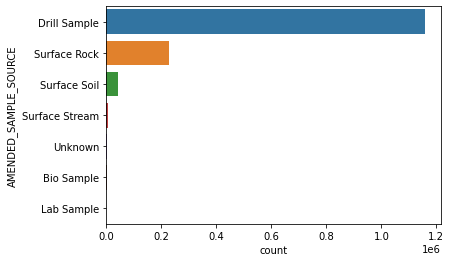

In [ ]:
sns.countplot(y='AMENDED_SAMPLE_SOURCE', data=df_grouped, order=df_grouped.AMENDED_SAMPLE_SOURCE.value_counts().index)

#### Distribution of Analytical Methods Present

Aside from the type of samples present, the other common source that results in various populations in a geochemical dataset is the type of methods used to analyse the sample. 

The choice of the analytical method is largely dependent on type of sample being analysed, the expected concentration of the element of interest in the sample and the cost of analysis. Each analytical method is usually optimised for different purposes and hence dependent on the use in mind. It is commonplace for different analytical methods to be chosen for each sample.

Below is a percent count and count plot of all the various analytical methods present within the dataset restricted to gold assays. It is a pretty comprehensive list and a lengthy one. 

In [ ]:
df.CHEM_METHOD_CODE.value_counts()/df.CHEM_METHOD_CODE.value_counts().sum()*100

FA1           16.413317
GG334          7.890612
FA2            6.488554
B/ETA          5.774045
Au-TL43        5.138390
UKN            4.944362
GG313          3.609214
FA50/AAS       3.579251
PAL            3.538741
P625           2.785818
FA             2.346426
B/SAAS         2.240402
AA26           2.084369
FA25N/SAAS     1.976879
B/AAS          1.905987
AA9            1.857864
Au-AA26        1.416307
ICP-OES        1.370070
AAS            1.158301
BLEG1C         1.134554
FA3            1.073580
ARM10          1.071345
IC3E           1.002199
GG329          0.973772
FA25/MS        0.765077
ARM3           0.753902
ARM2           0.715208
AA10           0.620219
B/MS           0.618892
AR/ICPES       0.593469
ICP-MS         0.520761
Au-ICP21       0.509027
FA25/AAS       0.480810
F650           0.453640
FA3E           0.447354
Au-ST44        0.419486
PE01S          0.391618
FA/SAAS        0.386519
Au-AA25        0.364099
FA001          0.356696
ME-MS41        0.353413
XRFNiton       0

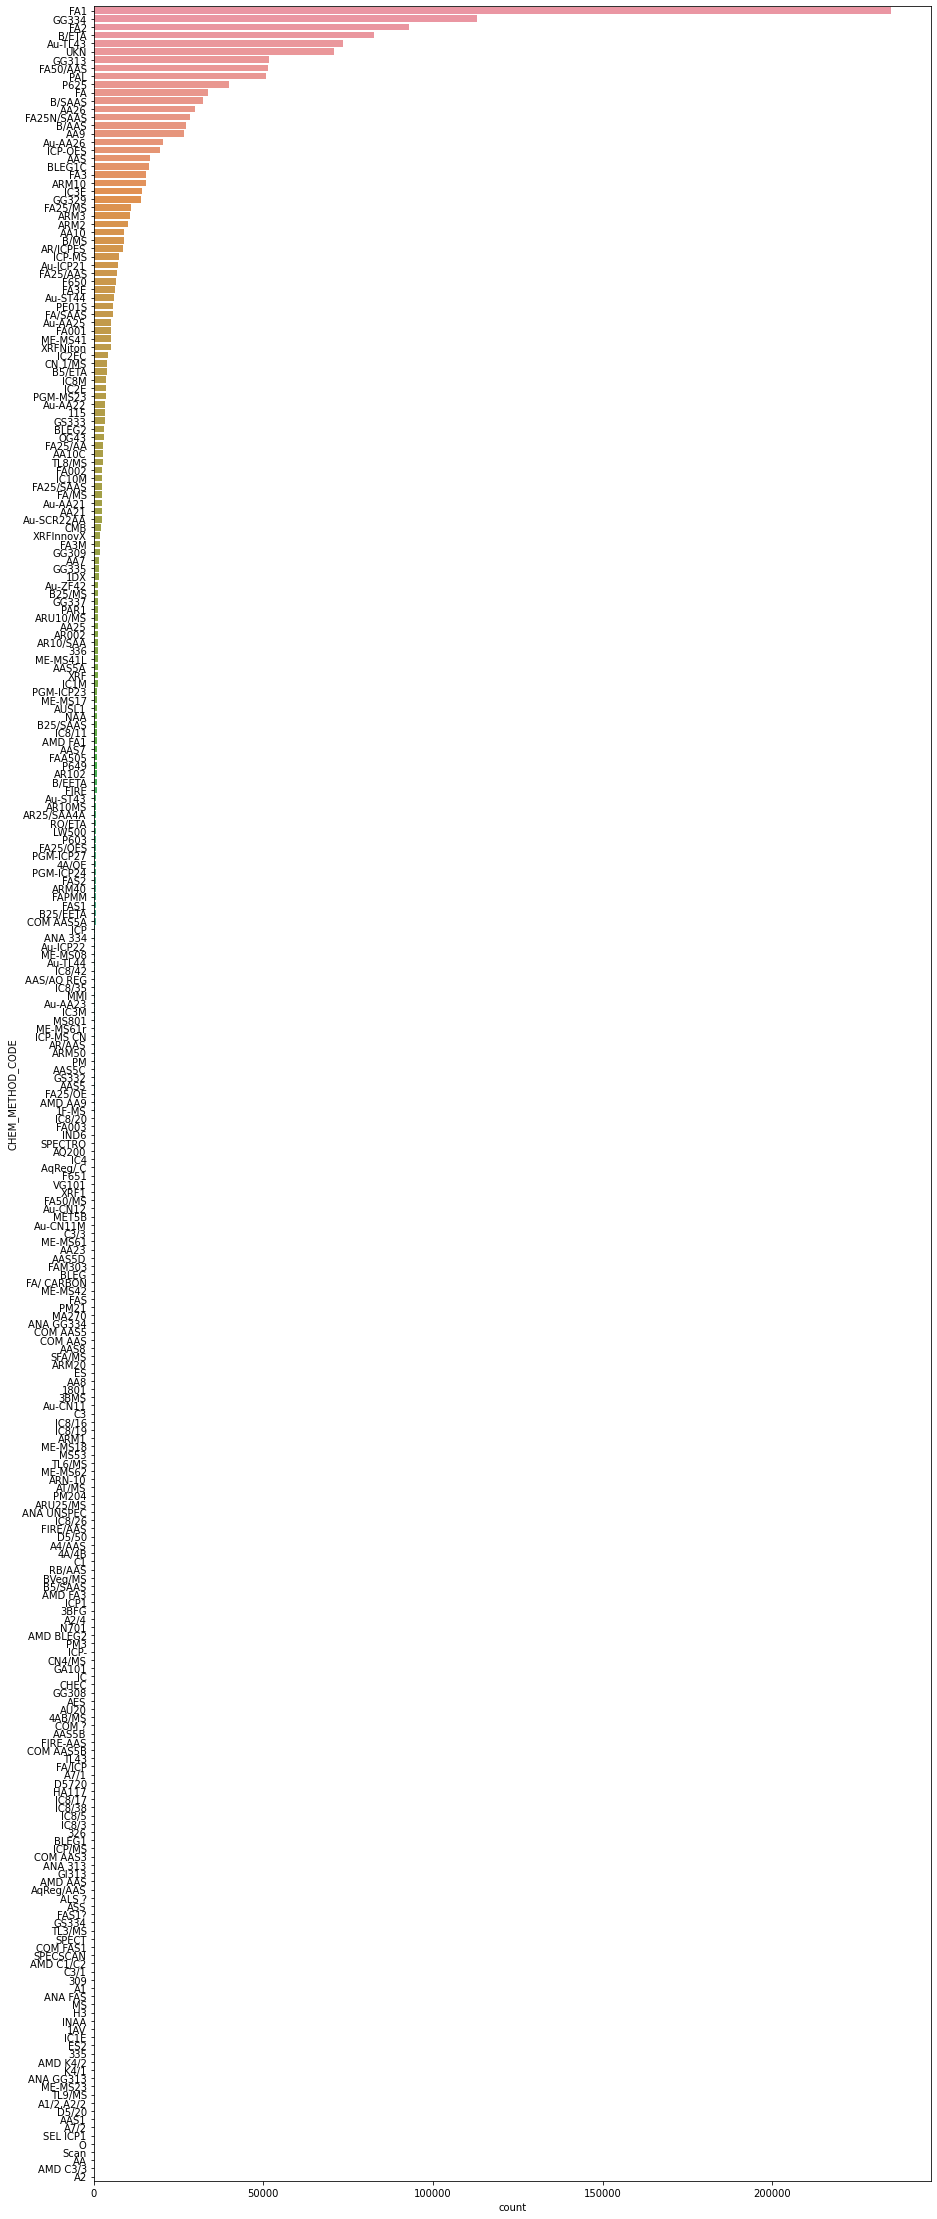

In [ ]:
plt.figure(figsize=(15,40))
sns.countplot(y='CHEM_METHOD_CODE', data=df, order=df.CHEM_METHOD_CODE.value_counts().index)

As a sanity check, looking at the top 20 analytical methods shows that they comprise ~80% of the methods used. Again this is something we would expect to see. Since majority of our samples are drilling samples, it makes sense that most of the samples were analysed using similar analytical methods - i.e. methods that are ideally suited for analysing drilling samples for Au. 

In [ ]:
#Sum of percent of top 20 counts
df.CHEM_METHOD_CODE.value_counts()[0:21].sum()/df.CHEM_METHOD_CODE.value_counts().sum()*100

78.72704211343864

#### Grouping Analytical Methods

As grouping sample types made it easier to see the effect of the various sample types in creating different populations, grouping analytical methods allowed us to better determine the relationship between the various analytical methods.

Again, as we are only interested in *Drilling Samples*, let's seperate these out before creating our original Au dataset and look at the distribution of analytical methods only within the drilling samples. 



In [ ]:
df_DH = df_grouped[df_grouped.AMENDED_SAMPLE_SOURCE == 'Drill Sample']

In [ ]:
#Preview drilling only data set
df_DH.head()

,MASTER_INDEX,SAMPLE_NO,SAMPLE_SOURCE_CODE,SAMPLE_SOURCE,ROCK_GROUP_CODE,ROCK_GROUP,LITHOLOGY_NAME,STRAT_CONF,STRAT_NAME,COLLECTED_BY,COLLECTED_DATE,DRILLHOLE_NUMBER,DH_NAME,DH_DEPTH_FROM,DH_DEPTH_TO,SITE_NO,EASTING_GDA2020,NORTHING_GDA2020,ZONE_GDA2020,LONGITUDE_GDA2020,LATITUDE_GDA2020,LONGITUDE_GDA94,LATITUDE_GDA94,SAMPLE_ANALYSIS_NO,ANALYSIS_TYPE_DESC,LABORATORY,CHEM_CODE,VALUE,UNIT,CHEM_METHOD_CODE,CHEM_METHOD_DESC,VALUE_INT,VALUE_INT_PPM,AMENDED_SAMPLE_SOURCE
75,10280.0,9448,DC,Drill core,IFI,Igneous Felsic Intrusive,Granite,NaN,NaN,"MCDONALD, J.",23/02/1960,133881.0,CR 1,NaN,NaN,121068,469669.41,6378552.83,53,134.676298,-32.730410,134.676288,-32.730396,5314,GEOCHEMISTRY,NaN,Au,<3,ppm,NaN,NaN,3.00,3.00,Drill Sample
100,11842.0,9765,CT,Drill cuttings,G,General/Miscellaneous,Clay (Undiff. Origin),NaN,NaN,"CROOKS, A.F.",09/02/1981,134275.0,TPS 17,22.00,NaN,121449,482929.32,6612173.35,53,134.821883,-30.622919,134.821874,-30.622905,5577,GEOCHEMISTRY,NaN,Au,<0.01,ppm,NaN,NaN,0.01,0.01,Drill Sample
108,12163.0,9779,DC,Drill core,IFE,Igneous Felsic Extrusive,Rhyodacite,NaN,Wiltabbie Volcanics,"DALY, S.J.",14/10/1983,6426.0,WILGENA 1,228.70,228.85,5511,465598.38,6603936.28,53,134.640778,-30.696873,134.640769,-30.696859,5588,GEOCHEMISTRY,NaN,Au,0.02,ppm,NaN,NaN,0.02,0.02,Drill Sample
109,12191.0,9785,DC,Drill core,SSL,Sediment Siliciclastic Lutite,Siltstone,NaN,Tarcoola Formation,"DALY, S.J.",14/10/1983,6426.0,WILGENA 1,553.25,553.33,5511,465598.38,6603936.28,53,134.640778,-30.696873,134.640769,-30.696859,5600,GEOCHEMISTRY,NaN,Au,<0.01,ppm,NaN,NaN,0.01,0.01,Drill Sample
110,12227.0,9788,DC,Drill core,IIE,Igneous Intermediate Extrusive,Andesite,NaN,Tarcoola Formation,"DALY, S.J.",14/10/1983,6426.0,WILGENA 1,622.70,622.80,5511,465598.38,6603936.28,53,134.640778,-30.696873,134.640769,-30.696859,5606,GEOCHEMISTRY,NaN,Au,0.01,ppm,NaN,NaN,0.01,0.01,Drill Sample


Below we grouped the analytical methods into common categories to make it easier to compare them with each other. The groups were created manually and then integrated into our data set.

In [ ]:
#Grouped manually
df_method = pd.read_csv('Cleaned_datasets/tmp/20_Geochem_Au_Class_Method.csv')

In [ ]:
df_method.head()

,CHEM_METHOD_DESC,CHEM_METHOD_Amended
0,A4/AAS,AAS
1,Acid dissolution followed by atomic absorption...,AAS
2,Atomic Absorption Spectrometry / Carbon Rod,AAS
3,Atomic Absorption Spectrometry (details and la...,AAS
4,Atomic Absorption Spectrometry,AAS


In [ ]:
#Dropping duplicates
df_method = df_method.drop_duplicates()

In [ ]:
#Generating Key-Value pairs for mapping new groups
method_map = dict(zip(df_method.CHEM_METHOD_DESC,df_method.CHEM_METHOD_Amended))
method_map

{'A4/AAS': 'AAS',
 'Acid dissolution followed by atomic absorption measurements on the cold vapour.': 'AAS',
 'Atomic Absorption Spectrometry / Carbon Rod': 'AAS',
 'Atomic Absorption Spectrometry (details and lab unspecified)': 'AAS',
 'Atomic Absorption Spectrometry': 'AAS',
 'Flame Atomic Absorption Spectrometry': 'AAS',
 'Flame Atomic Absorption Spectroscopy': 'AAS',
 'Graphite furnace atomic absorption spectrometry 25g charge, solvent extraction AAS determination.': 'AAS',
 'COMLABS AAS5': 'AAS',
 '30g; aqua regia digest, carbon rod collection, AAS determination.': 'AAS',
 '25g sample, aqua regia digest, AAS determination (Au).': 'AAS',
 'Aqua regia digestion, flame AAS.': 'AAS',
 'Aqua Regia digest, Atomic Absorption Spectrometry': 'AAS',
 '30g sample, aqua regia digest, AAS determination': 'AAS',
 'Aqua Regia digest, AAS': 'AAS',
 'Aqua regia digest, gold extracted with organic agent, analysis by atomic absorption spectroscopy.': 'AAS',
 'AA9': 'AAS',
 '30g; aqua regia; carbon r

In [ ]:
#Mapping to df
df_DH['AMENDED_CHEM_METHOD_CODE'] = df['CHEM_METHOD_DESC'].map(method_map)

C:\Users\Russell\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Let's see the new counts!

These fewer groups are much easier to compare.

In [ ]:
df_DH.AMENDED_CHEM_METHOD_CODE.value_counts()

FA_AAS           508661
AAS              295977
ICP-MS           114229
Unknown           49251
FA_UNK            38537
ICP-OES           29942
FA_ICP-OES         9394
FA_ICP-AES         8382
pXRF               6189
FA_ICP-MS          6113
ICP-MS/OES         5178
AAS/ICP-MS         3819
BLEG_ICP-MS        1306
FA_ICP             1243
FA_ICP-MS/AAS       561
ICP                 471
ICP-ES/MS           290
FA_NA               113
NNA                  70
BLEG                 57
ICP-MS/AES           39
FA_ICP-OES-MS        36
NAA                   6
Name: AMENDED_CHEM_METHOD_CODE, dtype: int64

In [ ]:
#saving the data
df_DH.to_csv('Cleaned_datasets/tmp/df_dh_grouped_all.csv', index=False)

#if you need to reload
# df_DH = pd.read_csv('Cleaned_datasets/tmp/df_dh_grouped_all.csv')

C:\Users\Russell\Anaconda3\envs\PythonGPU\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (4,5,6,7,8,27,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Checking the Assay Distribution within the New Grouped Analytical Methods

What do you think of this distribution?

Creating the new groupings allows us to see the distribution of Au values within each of them. The distributions shows that although there is overlap between the different methods, there are subtle differences between them as well. Comparing Au values between separate analytical methods might lead to some errors. Hence we will have to normalise the data between the various analytical methods before we interpret Au values between them.

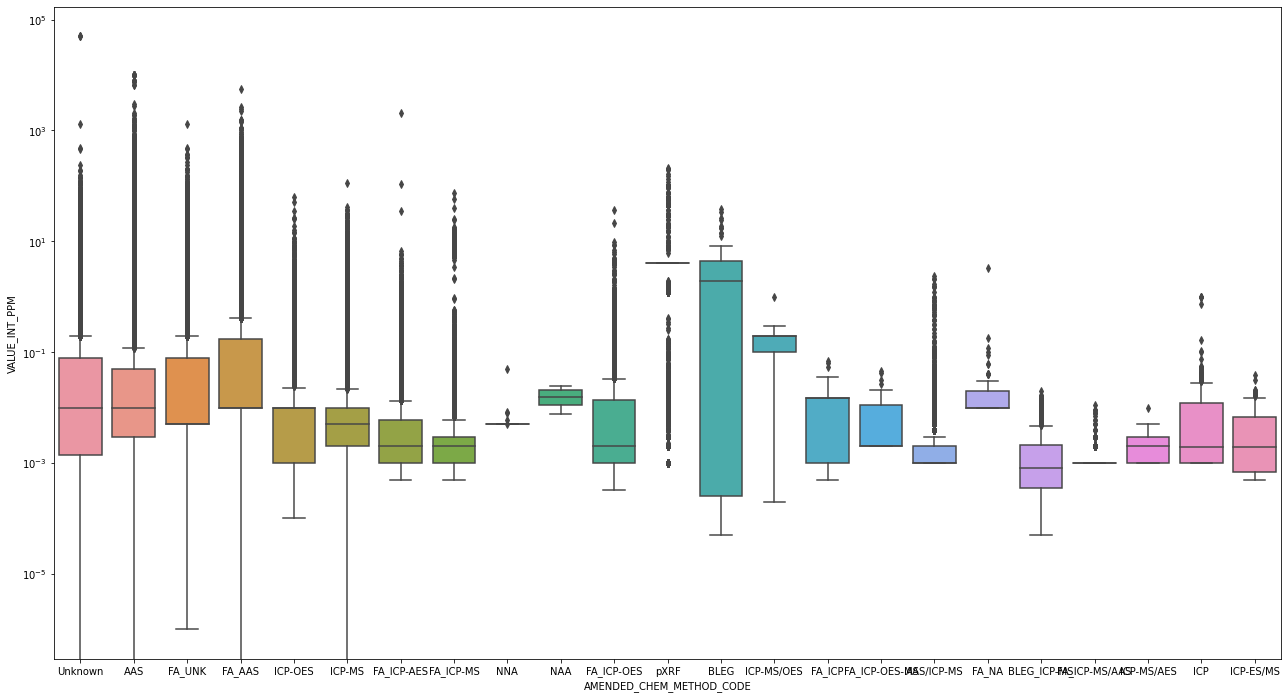

In [ ]:
plt.figure(figsize=(22, 12))

s = sns.boxplot(x='AMENDED_CHEM_METHOD_CODE', y='VALUE_INT_PPM', data=df_DH)
s.set_yscale("log")

### Z-SCORES for Assay

There are many methods of normalising data between different populations. We choose to use the standard Z-score normalisation as that is theoretically better for outlier detection while being blind to the populations present. Other methods are equally as valid.

One error we found in using the Z-score is that if you do not filter out the high (possibly unrealistic values out of your dataset) then the normalisation creates spurious results. An example being that if you leave a lot of the higher than expected max values in the dataset, then almost all the samples come back with a negative Z-score, meaning that most of the values lie below the mean. The mean ends up being very high if you do not carefully clean the high end values out of the dataset.

Maybe in this case, it is better to use the median instead of the mean? 


In [ ]:
#Calculating Zscores

df_DH['VALUE_INT_PPM_ZSCORE'] = (df_DH.VALUE_INT_PPM - df_DH.VALUE_INT_PPM.mean()/df_DH.VALUE_INT_PPM.std())

In [ ]:
df_DH['VALUE_INT_PPM_ZSCORE']

0          2.988717
1         -0.001283
2          0.008717
3         -0.001283
4         -0.001283
             ...   
1159011    0.028717
1159012    0.108717
1159013    0.058717
1159014    0.028717
1159015    0.018717
Name: VALUE_INT_PPM_ZSCORE, Length: 1159016, dtype: float64

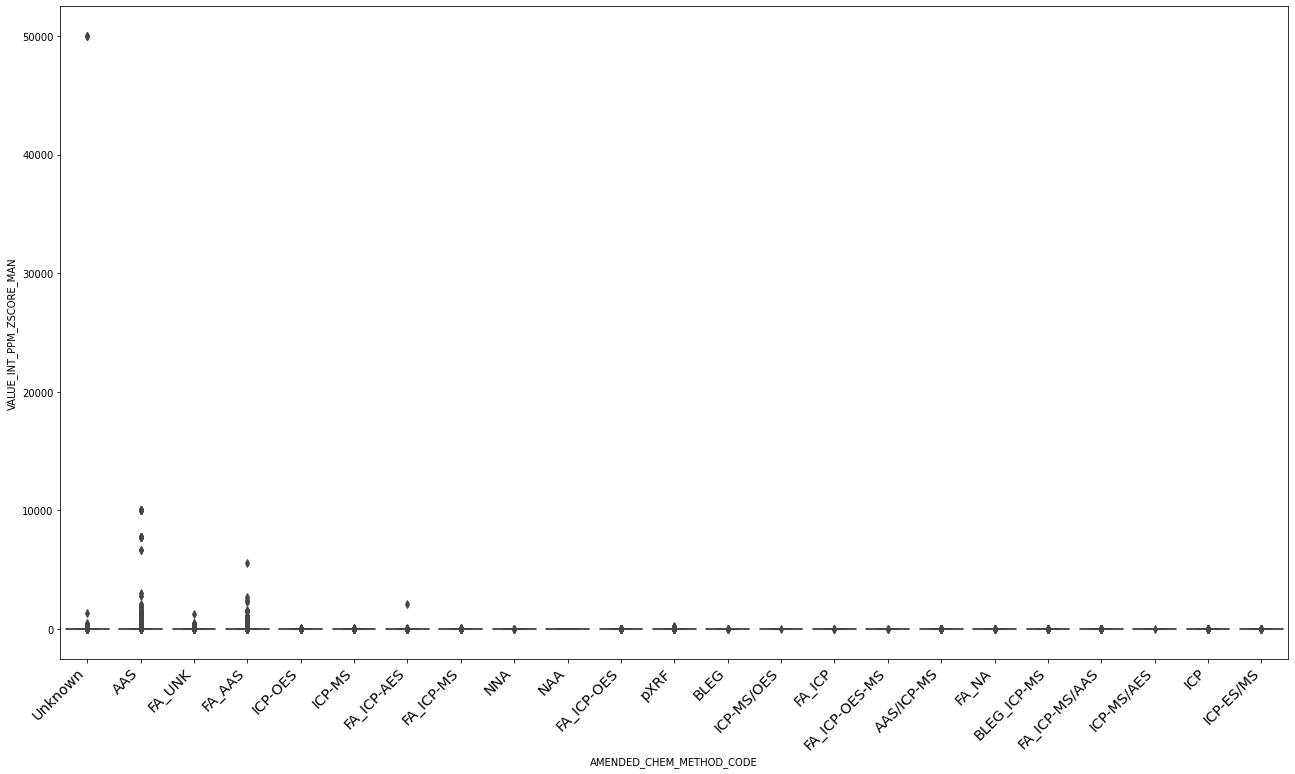

In [ ]:
#Previewing Z-Score distribution
plt.figure(figsize=(22, 12))

s = sns.boxplot(x='AMENDED_CHEM_METHOD_CODE', y='VALUE_INT_PPM_ZSCORE', data=df_DH)
s.set_xticklabels(
    s.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'
)

plt.show()

### 4. Formulating the Machine Learning Problem

Now that we have our Au data levelled and normalised based on the different populations we have present, we can use it to train a model. But before we do, we have to address the elephant in the room. 

As we are using drilling samples, we have multiple samples per drill hole - i.e. each drill hole is not represented by one sample but rather a number of samples along the length of the drill hole. Effectively, the drilling samples are a 3D dataset with a location in XY space and samples existing at different levels in the Z dimension. So how do we cater for that when we will be correlating the drilling samples to a 2D planar dataset like geophysical grids. 

One solution we tried is to take the max Au value for each drill hole and make that representative for the location of the drill hole. This way, each drill hole can be represented in 2D space with the max Au value in it and then that can be used to compare to the geophysical data present. We took the max value as we are interested in highlighting areas where there is anomalous Au present.

In [ ]:
#Calculating stats on each group of drill holes
df_DH_stats = df_DH[df_DH.DH_NAME.notna()].groupby(['DRILLHOLE_NUMBER', 'DH_NAME','LONGITUDE_GDA94', 'LATITUDE_GDA94'])['VALUE_INT_PPM'].agg(['count', 'max', 'min', 'mean', 'median']).reset_index()

Look at those high assays! We should have dealt with them earlier but no harm in taking them off now.

In [ ]:
df_DH_stats.sort_values(by='max', ascending=False)

,DRILLHOLE_NUMBER,DH_NAME,LONGITUDE_GDA94,LATITUDE_GDA94,count,max,min,mean,median
2211,136356.0,MK 4,134.141459,-30.215218,1,50000.0,50000.00,50000.000000,50000.000
501,6626.0,BUL 10,134.775396,-30.303629,1,50000.0,50000.00,50000.000000,50000.000
503,6632.0,BUL 16,134.781993,-30.334396,1,50000.0,50000.00,50000.000000,50000.000
34975,255693.0,07CUD0290,133.592547,-29.872133,106,10000.0,0.03,94.736981,0.155
34479,255197.0,06CUS1105,133.590058,-29.875956,33,10000.0,0.08,314.906061,0.600
...,...,...,...,...,...,...,...,...,...
2939,137621.0,KGB 19,137.128861,-35.735109,1,0.0,0.00,0.000000,0.000
2780,137462.0,STB 28,137.214803,-35.658614,1,0.0,0.00,0.000000,0.000
2779,137461.0,STB 22,137.214720,-35.687100,1,0.0,0.00,0.000000,0.000
2942,137624.0,KGB 29,137.149057,-35.707878,1,0.0,0.00,0.000000,0.000


49 drill holes have max assays >1000ppm. Earlier we mentioned that any assays >1000ppm are unlikely to be realistic values. So we removed this assays from our dataset and will validate them later. 


In [ ]:
#Assays greater than 1000ppm
len(df_DH_stats[df_DH_stats['max'] > 1000].sort_values(by='max', ascending=False))

49

In [ ]:
#A preview of those assays
df_DH_stats[df_DH_stats['max'] > 1000].sort_values(by='max', ascending=False)

,DRILLHOLE_NUMBER,DH_NAME,LONGITUDE_GDA94,LATITUDE_GDA94,count,max,min,mean,median
501,6626.0,BUL 10,134.775396,-30.303629,1,50000.00,50000.000,50000.000000,50000.0000
2211,136356.0,MK 4,134.141459,-30.215218,1,50000.00,50000.000,50000.000000,50000.0000
503,6632.0,BUL 16,134.781993,-30.334396,1,50000.00,50000.000,50000.000000,50000.0000
34479,255197.0,06CUS1105,133.590058,-29.875956,33,10000.00,0.080,314.906061,0.6000
34975,255693.0,07CUD0290,133.592547,-29.872133,106,10000.00,0.030,94.736981,0.1550
50786,330043.0,LRC192,134.779543,-31.201910,150,9999.00,0.010,66.687867,0.0100
50777,330034.0,LRC184,134.769148,-31.234668,134,9999.00,0.010,74.683134,0.0100
50758,330015.0,LRC165,134.760141,-31.218307,135,9999.00,0.010,74.091111,0.0100
50698,329955.0,LRC105,134.748774,-31.208308,132,9999.00,0.010,75.775682,0.0100
50690,329947.0,LRC097B,134.755167,-31.213515,153,9999.00,0.010,65.461373,0.0400


Let's take these off and create a new df. We can also see the new distribution of the *Max* values using a box plot.

In [ ]:
#New filtered data set
df_DH_stats_filtered = df_DH_stats[df_DH_stats['max'] < 1000]

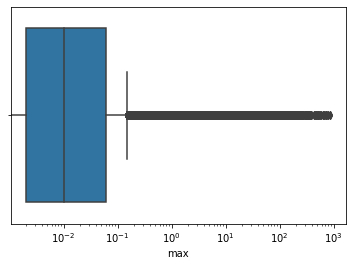

In [ ]:
#Distribution
s = sns.boxplot(df_DH_stats_filtered['max'])
s.set_xscale("log")

In [ ]:
#Saving to file
df_DH_stats_filtered.to_csv('Cleaned_datasets/tmp/df_DH_stats_filt1.csv')

In [ ]:
#Summary
df_DH_stats_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51756 entries, 0 to 51804
Data columns (total 9 columns):
DRILLHOLE_NUMBER    51756 non-null float64
DH_NAME             51756 non-null object
LONGITUDE_GDA94     51756 non-null float64
LATITUDE_GDA94      51756 non-null float64
count               51756 non-null int64
max                 51756 non-null float64
min                 51756 non-null float64
mean                51756 non-null float64
median              51756 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 3.9+ MB


In [ ]:
df_DH_stats_filtered.head()

,DRILLHOLE_NUMBER,DH_NAME,LONGITUDE_GDA94,LATITUDE_GDA94,count,max,min,mean,median
0,148.0,BN 1,129.166969,-31.168817,19,0.050,0.001,0.047421,0.050
1,149.0,BN 2,129.163516,-31.162467,47,0.050,0.001,0.046872,0.050
2,262.0,KN 1,129.707292,-31.323613,4,0.050,0.001,0.037750,0.050
3,353.0,MALLABIE 1,130.603062,-31.535802,1,0.001,0.001,0.001000,0.001
4,897.0,NDR 11,132.077106,-31.643917,1,0.010,0.010,0.010000,0.010


### Machine Learning Dataset - Integrate the Geophysics!

Now that we have a representation of an assay value on a 2d plane(map), we need to extract the corresponding gravity, mag and other PF data sets for those points.
Grid's are an interpolated product obtained by averaging values of data points from its surrounding. Hence, we can extract the grid value from the point directly below the drill hole location instead of creating a buffer around the location and extracting values from that polygon.

The data set below is for drill holes within the white polygon. We will train our model with data extracted from within that area and test it within areas where there are known deposits to see how if the model can identify those.


I'll skip the part on __how to use QGIS to extract raster data at vector points locations__. A quick Google search of that text will give you the answer, otherwise you could always request a tutorial in this forum.

![map](map.png)

Our [Analytical Base Table](https://en.wikipedia.org/wiki/Analytical_base_table) contains four geophysical features (columns) and several assay statistics extracted for every drill hole. We will use the *Max* statistic along with the four geophysical features to formulate our ML model.


In [ ]:
df_abt = pd.read_csv('Cleaned_datasets/ABT_AOI.csv')
df_abt['DH_NO'] = df_abt.DH_NO.astype(int)

In [ ]:
df_abt.head()

,DH_NO,DH_NAME,LONG_GDA94,LAT_GDA94,COUNT,MAX,MIN,MEAN,MEDIAN,GRAV,GRAV_1VD,TMI,TMI_1VD
0,9989,MOUNT WOODS 1,135.48720,-29.61676,5,0.010,0.002,0.00480,0.004,20.42488,-0.00311,149.06245,-4.51517
1,10077,83ERC 2,135.10888,-29.24497,4,0.050,0.000,0.01250,0.000,-7.10213,-0.00100,-519.38226,-0.11109
2,10081,DD87BB 2,135.46734,-29.43277,3,0.017,0.008,0.01400,0.017,7.82398,0.00013,8194.04492,30.29026
3,14114,SR1,135.90526,-29.75179,5,3.000,0.001,0.60120,0.001,-5.89984,0.00712,1044.38806,0.64144
4,14123,WARRINER CREEK 1,135.76632,-29.45852,7,0.004,0.001,0.00171,0.001,-5.35701,0.00115,-211.87364,0.81135


In [ ]:
df_abt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1335 entries, 0 to 1334
Data columns (total 13 columns):
DH_NO         1335 non-null int32
DH_NAME       1335 non-null object
LONG_GDA94    1335 non-null float64
LAT_GDA94     1335 non-null float64
COUNT         1335 non-null int64
MAX           1335 non-null float64
MIN           1335 non-null float64
MEAN          1335 non-null float64
MEDIAN        1335 non-null float64
GRAV          1335 non-null float64
GRAV_1VD      1335 non-null float64
TMI           1335 non-null float64
TMI_1VD       1335 non-null float64
dtypes: float64(10), int32(1), int64(1), object(1)
memory usage: 130.5+ KB


### Features for building the model

- Gravity
- First Verical Derivative of Gravity
- Magnetic (TMI)
- First Verical Derivative of Magnetic (TMI)

In [ ]:
X = df_abt[['GRAV', 'GRAV_1VD', 'TMI', 'TMI_1VD']]
X.head()

,GRAV,GRAV_1VD,TMI,TMI_1VD
0,20.42488,-0.00311,149.06245,-4.51517
1,-7.10213,-0.00100,-519.38226,-0.11109
2,7.82398,0.00013,8194.04492,30.29026
3,-5.89984,0.00712,1044.38806,0.64144
4,-5.35701,0.00115,-211.87364,0.81135


### Target Variable - Regresson or classification problem?

As we mentioned before, there are two ways to deal with this problem. You can either create a classification model using the dataset or a regression model using the dataset. What is your preference? 

For us it seems like classification is a better approach as it is unrealistic to think that we would be able to geophysical response to predict the gold grade in a drilling sample or drill hole. But leave it up to you to decide how you want to go about doing this. 


#### Regression - 

For every coordinate (point) corresponding to the geophysical data you will predict an assay value. Sounds too good to be true right? Make sure that you are aware of the assumptions and limitations of this technique. No technique is incorrect if you can justify your reasons for doing it.

*y_reg* will be your target variable if you follow the regression pathway.

In [ ]:
y_reg = df_abt['MAX']
y_reg

0       0.010
1       0.050
2       0.017
3       3.000
4       0.004
        ...  
1330    2.000
1331    2.000
1332    2.000
1333    2.000
1334    2.000
Name: MAX, Length: 1335, dtype: float64

#### Classification -

We create two classes here. Assays greater than 100ppm are targets. Now for every coordinate point(row), you will use the corresponding geophysical data to place that point within either a **Target (1)** class or **No Target (0)** class.

Some would argue that >100ppm is a high threshold. But we are just testing out the approach so you should feel free to adjust this down if you like. 


In [ ]:
df_abt['Max_classes'] = np.where(df_abt['MAX'] > 100, 1, 0)

In [ ]:
df_abt.Max_classes.unique()

array([0, 1], dtype=int64)

#### Imbalanced Classes

We thought it's worthwile to mention this because it is a classic problem in geochemical datasets. 

Like most real world data, our data set similarly has imbalance in classes. As you can see bellow, the class that we want to predict represents less than 1% of our data set - which makes sense as we are trying to identify anomalies in our dataset. Model accuracy is quite dependent on how one solves or accounts for this class imbalance problem.



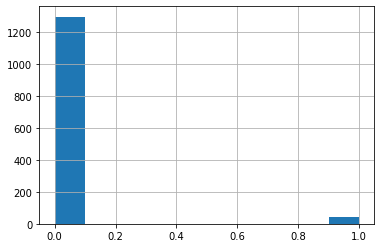

In [ ]:
df_abt.Max_classes.hist()

That's it. You are now ready to run your model and interrogate the results to see whether this approach allows you to identify prospective areas for gold mineralisation. 

As we have mentioned, this is a very simplistic view of how to try to use the various datasets to try to build a machine learning model. There are levels of sophistication one can add at every step. Feel free to do so as it will make your training dataset more robust and allow you to make better predictions. We are trying out a few of these so feel free to discuss on the forum. And if you have any comments on how to improve our approach or things we should eliminate, then please feel free to comment as well. 

Good luck with this challenge!!!
